# Test suite for a Neural Network to predict the rest-eigen part

In [1]:
using LmaPredict, Statistics, Flux, ProgressMeter, Plots, StatsBase, Random, LaTeXStrings

## Reading the data

In [2]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [3]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]
em_n = "VV"

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em=em_n, bc=false))
end

## Splitting data in training and test sets

In [4]:
NCNFG = length(cnfgarr)
train_size = 500
test_size = NCNFG - train_size

TSRC = "24"
TVALS = length(cnfgarr[1].data["rr"][TSRC]) - 1
if em_n == "PA"
    EIGVALS = 32
else 
    EIGVALS = 64
end

eigvals_data_train = Array{Float64}(undef, EIGVALS, train_size)
rr_data_train = Array{Float64}(undef, TVALS, train_size)
ee_data_train = Array{Float64}(undef, TVALS, train_size)
re_data_train = Array{Float64}(undef, TVALS, train_size)

eigvals_data_test = Array{Float64}(undef, EIGVALS, test_size)
rr_data_test = Array{Float64}(undef, TVALS, test_size)
ee_data_test = Array{Float64}(undef, TVALS, test_size)
re_data_test = Array{Float64}(undef, TVALS, test_size)

for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:train_size])
    eigvals_data_train[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_train[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_train[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_train[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[train_size+1:NCNFG])
    eigvals_data_test[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_test[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

## Defining training and test data

In [5]:
input_length = 2*TVALS 
output_length = TVALS

#input_shape_train = vcat(sort(1 ./ eigvals_data_train, dims=1), ee_data_train, rr_data_train)
input_shape_train = vcat(ee_data_train, rr_data_train)
output_shape_train = re_data_train

#input_shape_test = vcat(sort(1 ./ eigvals_data_test, dims=1), ee_data_test, rr_data_test)
input_shape_test = vcat(ee_data_test, rr_data_test)
output_shape_test = re_data_test;

### Input data, normalized and standardized

In [6]:
max_input_train = maximum(input_shape_train)
min_input_train = minimum(input_shape_train)

mean_input_train = mean(input_shape_train, dims=ndims(input_shape_train))
std_input_train = std(input_shape_train, dims=ndims(input_shape_train))

input_data_train_normalized = (input_shape_train .- max_input_train) ./ (max_input_train - min_input_train) 
input_data_train_standardized = (input_shape_train .- mean_input_train) ./ std_input_train

input_data_test_normalized = (input_shape_test .- max_input_train) ./ (max_input_train - min_input_train)
input_data_test_standardized = (input_shape_test .- mean_input_train) ./ std_input_train;

### Output data, normalized and standardized

In [7]:
max_output_train = maximum(output_shape_train)
min_output_train = minimum(output_shape_train)

mean_output_train = mean(output_shape_train, dims=ndims(output_shape_train))
std_output_train = std(output_shape_train, dims=ndims(output_shape_train))

output_data_train_normalized = (output_shape_train .- max_output_train) ./ (max_output_train - min_output_train)
output_data_train_standardized = (output_shape_train .- mean_output_train) ./ std_output_train;

## Defining the Network

In [472]:
model = Chain(
    Dense(input_length => 1000, tanh),
    Dropout(0.8),
    Dense(1000 => output_length, identity)
    ) |> f64

Chain(
  Dense(94 => 1000, tanh),              # 95_000 parameters
  Dropout(0.8),
  Dense(1000 => 47),                    # 47_047 parameters
)                   # Total: 4 arrays, 142_047 parameters, 1.084 MiB.

### Defining loader, optimizer and loss function

In [473]:
Random.seed!(20)
loader = Flux.DataLoader((input_data_train_standardized, output_data_train_standardized), batchsize=32, shuffle=true) 

# Flux.AdaGrad(), Flux.AdaDelta(), Flux.AMSGrad(), Flux.NAdam()
optim = Flux.setup(Flux.Adam(1e-3), model)
#optim = Flux.setup(OptimiserChain(WeightDecay(0.00001), Adam(0.00001)), model)
#optim = Flux.setup(Flux.Optimise.Optimiser(Adam(), WeightDecay(1.0)), model)


function loss(flux_model, x, y)
    batch_size = size(x)[2]
    ŷ = flux_model(x)
    
    return Flux.mse(ŷ, y, agg=sum) + mean(abs.((sum.([ŷ[:,i] for i in 1:batch_size]) - sum.([y[:,i] for i in 1:batch_size]))))
    #return Flux.mse(ŷ, y, agg=sum)
end

loss (generic function with 1 method)

## Training the Network

In [474]:
mean_train = repeat(mean.([output_shape_train[i,:] for i in 1:output_length]), 1, test_size)

losses = []
R_scores = []
R = -Inf

epochs = 900
@showprogress for epoch in 1:epochs
    if epoch > 2
        optim = Flux.setup(Flux.Adam(1e-5), model)
    end
    if epoch > 400
        optim = Flux.setup(Flux.Adam(1e-6), model)
    end
        
    for (x, y) in loader
        grads = gradient(m -> loss(m, x, y), model)
        Flux.update!(optim, model, grads[1])
        push!(losses,loss(model, x, y))
    end
    out_of_sample_predictions = (model(input_data_test_standardized) .* std_output_train) .+ mean_output_train
    
    R = 1 - (Flux.mse(out_of_sample_predictions, output_shape_test, agg=sum) / Flux.mse(mean_train, output_shape_test, agg=sum))

    push!(R_scores, R)
    loader = Flux.DataLoader((input_data_train_standardized, output_data_train_standardized), batchsize=32, shuffle=true) 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


## Checking loss dynamics during training

Maximum R: 0.3247302513611827


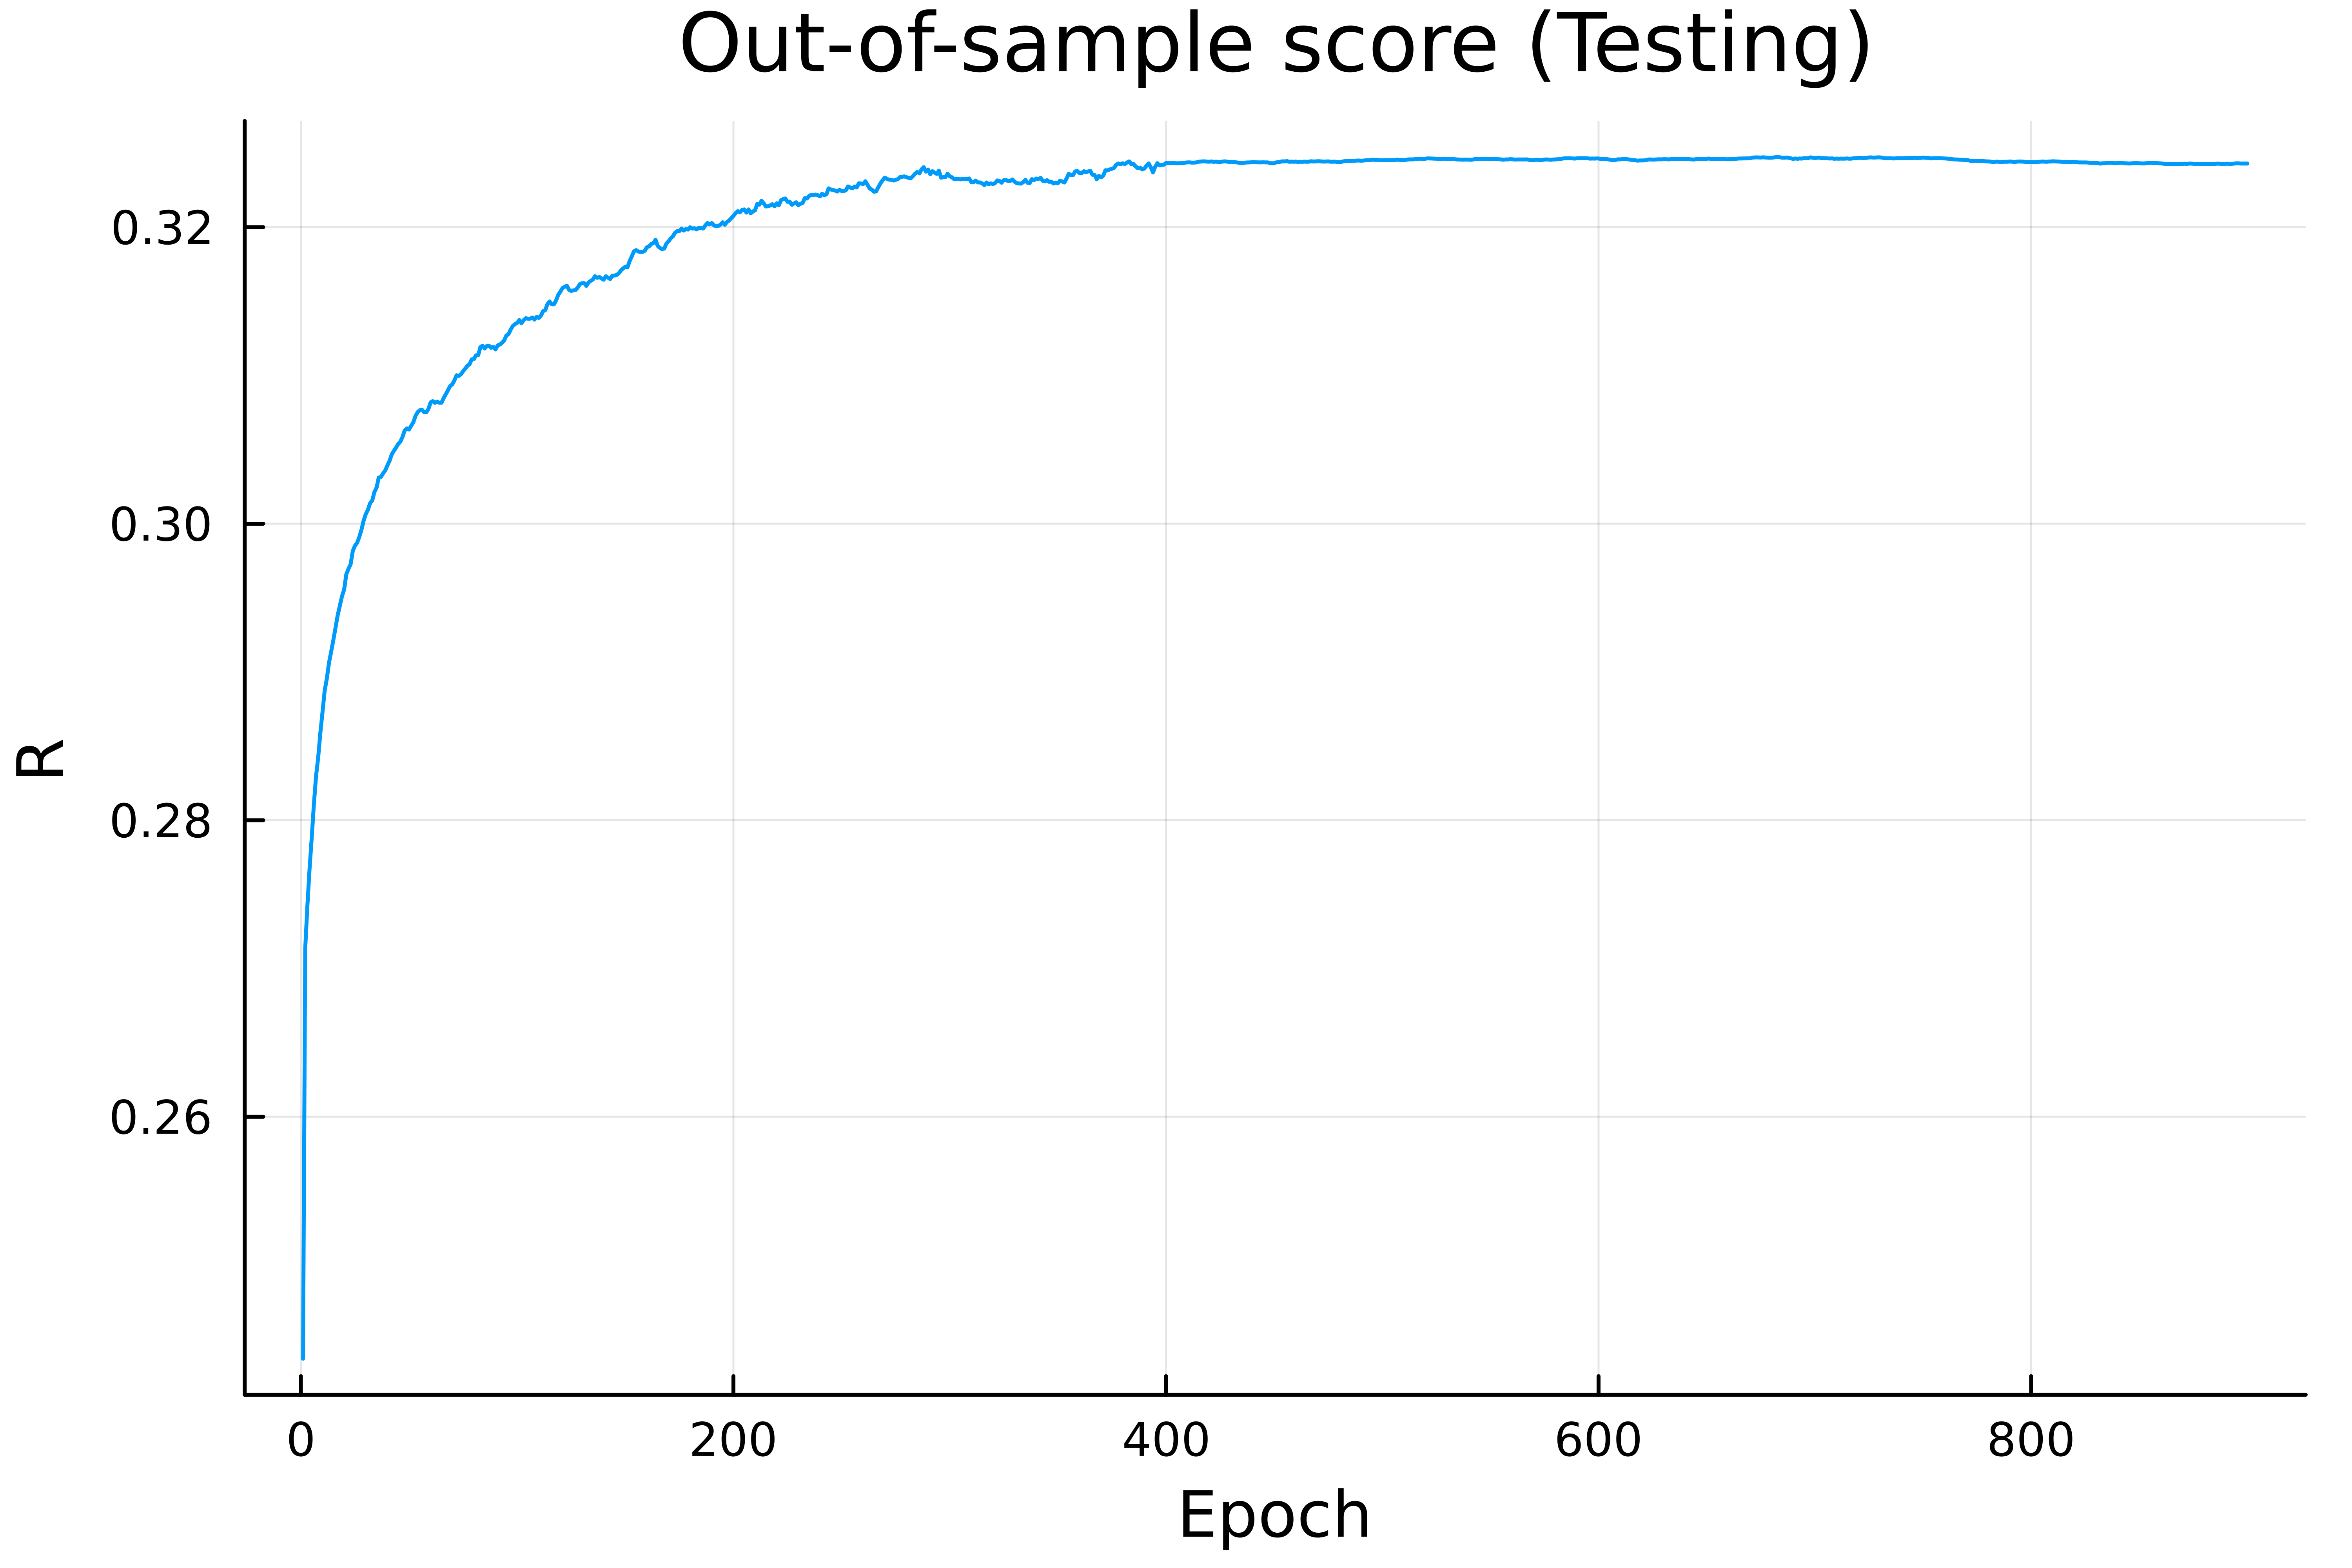

In [475]:
println("Maximum R: ", maximum(R_scores))

plot(R_scores, title="Out-of-sample score (Testing)", legend=:false, dpi=1000)
xlabel!("Epoch")
ylabel!("R")
#savefig("R_Score.png")

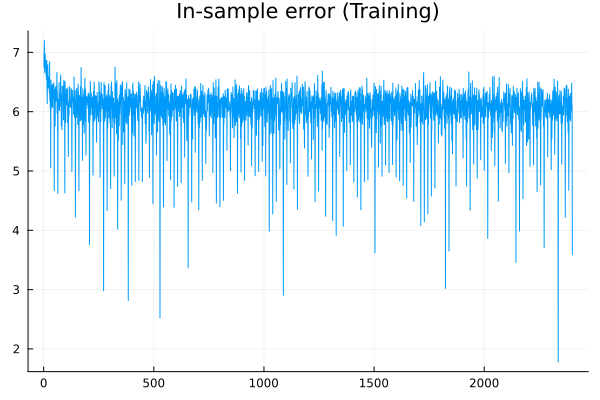

In [430]:
plot(log.(losses .- minimum(losses)), title="In-sample error (Training)", legend=:false)


## Checking out-of-sample results

In [476]:
out_of_sample_predictions = (model(input_data_test_standardized) .* std_output_train) .+ mean_output_train

mean_train = repeat(mean.([output_shape_train[i,:] for i in 1:output_length]), 1, test_size)

out_of_sample_score = 1 - (Flux.mse(out_of_sample_predictions, output_shape_test, agg=sum) / Flux.mse(mean_train, output_shape_test, agg=sum))

println("Out of sample score: ", out_of_sample_score)

Out of sample score: 0.32429240283692196


In [161]:
p = scatter(
    size=(1400,1000),
    dpi = 1000,
    thickness_scaling = 1.8
)
    
scatter!(p,
    mean.([output_shape_train[i,:] for i in 1:output_length]),
    label="mean train",
    legend=:top,
    linecolor=:blue,
    markershape=:hline,
    markersize = 2,
    markerstrokewidth = 0.3
)

scatter!(p,
    mean.([output_shape_test[i,:] for i in 1:output_length]),
    label="mean test",
    legend=:top,
    linecolor=:red,
    markershape=:hline,
    markersize = 4,
    markerstrokewidth = 0.3
)

scatter!(p,
    mean.([out_of_sample_predictions[i,:] for i in 1:output_length]),
    label="mean prediction",
    legend=:top,
    linecolor=:green,
    markershape=:hline,
    markersize = 2,
    markerstrokewidth = 0.3
)

In [477]:
x_start = 8
x_end = 40

num_sample_configs = 9
sample_configs = sort!(sample([i for i in 1:test_size], num_sample_configs, replace = false))

l = @layout [a b c; d e f; g h i]

p = plot(layout = l, size=(1200,1000), dpi=1000)

scatter!(p, output_shape_test[:,sample_configs], label="Actual", legend=:top, markerstrokewidth = 0)
scatter!(p, out_of_sample_predictions[:,sample_configs], label="Prediction", legend=:top, markerstrokewidth = 0)
savefig(p,"samples_all.png")

p = plot(layout = l, size=(1200,1000), dpi=1000)

scatter!(p,
    output_shape_test[x_start:x_end,sample_configs],
    label="Actual",
    legend=:bottom,
    markerstrokewidth = 0,
    xticks=([i for i in 1:5:(x_end-x_start)+1],["$i" for i in x_start:5:x_end])
)

scatter!(p,
    out_of_sample_predictions[x_start:x_end,sample_configs],
    label="Prediction",
    legend=:bottom,
    markerstrokewidth = 0,
    xticks=([i for i in 1:5:(x_end-x_start)+1],["$i" for i in x_start:5:x_end])
)
#savefig(p,"samples_zoomed.png")

# Bias correction

### Applying bias correction on a percentage of the test data

In [516]:
num_tests = 100
percentages = [0.0, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]
seeds = rand([i for i in 1:1_000_000], num_tests)

for percentage in percentages
    num_no_overlappings = zeros(num_tests)
    χ²_s = zeros(num_tests)
    χ²_train_s = zeros(num_tests)
    i = 1
    for test in 1:num_tests
        n_configs = Int(test_size * percentage)

        Random.seed!(seeds[test])
        configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))
        
        uncorr_target_configs = stack(deleteat!([output_shape_test[:,i] for i in 1:test_size],configs), dims=2)
        
        mean_target = mean(uncorr_target_configs, dims=2)
        σ_mean_target = std(uncorr_target_configs, dims=2) ./ sqrt(test_size - 1 - n_configs)

        mean_target_train = mean(output_shape_train, dims=2)
        σ_mean_target_train = std(output_shape_train, dims=2) ./ sqrt(train_size - 1)
            
        mean_predicted = mean(out_of_sample_predictions, dims=2)
        σ_predicted = std(out_of_sample_predictions, dims=2) ./ sqrt(test_size - 1)
        
        if percentage > 0
            bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
            σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)
            
            mean_target_train = mean(hcat(output_shape_train, hcat([output_shape_test[:,i] for i in configs]...)), dims=2)
            σ_mean_target_train = std(hcat(output_shape_train, hcat([output_shape_test[:,i] for i in configs]...)), dims=2) ./ sqrt(train_size + n_configs - 1)
        else
            bias_correction = zeros(output_length)
            σ_bc = zeros(output_length)
        end
        
        mean_predicted = mean_predicted - bias_correction
        σ_pred_bc = σ_predicted + σ_bc
        
        χ²_s[i] = sum(((mean_predicted - mean_target) ./ sqrt.(σ_pred_bc.^2 + σ_mean_target.^2)).^2)
        χ²_train_s[i] = sum(((mean_target_train - mean_target) ./ sqrt.(σ_mean_target_train.^2 + σ_mean_target.^2)).^2)

        no_overlaps = 0
        for t in 1:output_length
            predicted_min = mean_predicted[t] - σ_pred_bc[t]
            predicted_max = mean_predicted[t] + σ_pred_bc[t]
        
            target_min = mean_target[t] - σ_mean_target[t]
            target_max = mean_target[t] + σ_mean_target[t]
        
            if predicted_min > target_max || predicted_max < target_min
                no_overlaps += 1
            end
        end

        num_no_overlappings[i] = no_overlaps
        i += 1
    end

    mean_no_overlappings = mean(num_no_overlappings)
    mean_χ² = mean(χ²_s)
    maximum_χ² = maximum(χ²_s)
    mean_χ²_train = mean(χ²_train_s)
    maximum_χ²_train = maximum(χ²_train_s)
    println("Percentage used for bias-correction: $percentage")
    println("Average number of non-overlappings: $mean_no_overlappings")
    println("<χ²>: $mean_χ², max χ²: $maximum_χ²")
    println("<χ²_train>: $mean_χ²_train, max χ²_train: $maximum_χ²_train\n")
end     

Percentage used for bias-correction: 0.0
Average number of non-overlappings: 36.0
<χ²>: 335.6364732317107, max χ²: 335.6364732317108
<χ²_train>: 130.06052045980366, max χ²_train: 130.06052045980368

Percentage used for bias-correction: 0.01
Average number of non-overlappings: 9.03
<χ²>: 36.78604444642673, max χ²: 108.50213486570576
<χ²_train>: 123.62538526917218, max χ²_train: 158.50444570105353

Percentage used for bias-correction: 0.02
Average number of non-overlappings: 6.84
<χ²>: 31.858276693853227, max χ²: 95.34571705939342
<χ²_train>: 117.22449869736772, max χ²_train: 175.47866311607248

Percentage used for bias-correction: 0.04
Average number of non-overlappings: 5.82
<χ²>: 31.05190668591565, max χ²: 101.74108650352059
<χ²_train>: 106.26746923152244, max χ²_train: 175.9215692918186

Percentage used for bias-correction: 0.08
Average number of non-overlappings: 5.16
<χ²>: 29.95557798111101, max χ²: 84.23494401211248
<χ²_train>: 91.27074673364793, max χ²_train: 162.92899093235587



In [513]:
x_start = 8
x_end = 40

percentage = 0.1
n_configs = Int(test_size * percentage)        
configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))
        
uncorr_target_configs = stack(deleteat!([output_shape_test[:,i] for i in 1:test_size],configs), dims=2)
        
mean_target = mean(uncorr_target_configs, dims=2)
σ_mean_target = std(uncorr_target_configs, dims=2) ./ sqrt(test_size - 1 - n_configs)

mean_target_train = mean(output_shape_train, dims=2)
σ_mean_target_train = std(output_shape_train, dims=2) ./ sqrt(train_size - 1)
            
mean_predicted = mean(out_of_sample_predictions, dims=2)
σ_predicted = std(out_of_sample_predictions, dims=2) ./ sqrt(test_size - 1)
        
if percentage > 0
    bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
    σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)

    mean_target_train = mean(hcat(output_shape_train,hcat([output_shape_test[:,i] for i in configs]...)), dims=2)
    σ_mean_target_train = std(hcat(output_shape_train,hcat([output_shape_test[:,i] for i in configs]...)), dims=2) ./ sqrt(train_size + n_configs - 1)
else
    bias_correction = zeros(output_length)
    σ_bc = zeros(output_length)
end
        
mean_predicted = mean_predicted - bias_correction
σ_pred_bc = σ_predicted + σ_bc

no_overlaps = 0
for t in 1:output_length
    predicted_min = mean_predicted[t] - σ_pred_bc[t]
    predicted_max = mean_predicted[t] + σ_pred_bc[t]
        
    target_min = mean_target[t] - σ_mean_target[t]
    target_max = mean_target[t] + σ_mean_target[t]
        
    if predicted_min > target_max || predicted_max < target_min
        println("Errors are not overlapping on t = $t")
    end
end

χ² = sum(((mean_predicted - mean_target) ./ sqrt.(σ_pred_bc.^2 + σ_mean_target.^2)).^2)
χ²_train = sum(((mean_target_train - mean_target) ./ sqrt.(σ_mean_target_train.^2 + σ_mean_target.^2)).^2)
println("χ² = ", χ²)
println("χ²_train = ", χ²_train)

p = scatter(
    size=(1400,1000),
    dpi = 1000,
    thickness_scaling = 1.6,
    title="bc: $n_configs"
)
    
#scatter!(p,
#    mean_target[x_start:x_end],
#    yerr=σ_mean_target[x_start:x_end],
#    label="actual",
#    legend=:bottom,
#    linecolor=:blue,
#    marker=:xcross,
#    markersize = 2,
#    markerstrokewidth = 0.3,
#    xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
#)

scatter!(p,
    mean_predicted[x_start:x_end],
    yerr=σ_pred_bc[x_start:x_end],
    label="predicted",
    legend=:bottom,
    linecolor=:red,
    marker =:+,
    markersize = 2,
    markerstrokewidth = 0.3,
    xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
)

scatter!(p,
    mean_target_train[x_start:x_end],
    yerr=σ_mean_target_train[x_start:x_end],
    label="actual (training set)",
    legend=:bottom,
    linecolor=:yellow,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.3,
    xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
)

xlabel!(p,L"t/a")
ylabel!(p,L"C^{re}(x_0,y_0)")
#savefig(p,"prediction_mean_bc.png")

Errors are not overlapping on t = 5
Errors are not overlapping on t = 6
Errors are not overlapping on t = 7
Errors are not overlapping on t = 41
Errors are not overlapping on t = 42
χ² = 27.155317065883196
χ²_train = 93.58614761428089
